# Goals and methods
In this notebook, we will be using 'Segmentation_models.pytorch' to setup the different neural network architectures and experiment with different parameters. We will be using 'Albumentations' for data augmentation, given we have a pretty small dataset to work with. The whole implementation is based on pytorch, so that will be the 'glue' in our project, to put it all together

# 1. Imports

In [1]:
# Data tools
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import numpy as np
import json

# Data visualization
import cv2
import matplotlib.pyplot as plt
from PIL import Image, ImageDraw

# Data loading and manipulation
from torch.utils.data import DataLoader
from packages.dataset import Dataset
import albumentations as albu
from packages.helpers import *

# Machine Learning model and training
import torch
import segmentation_models_pytorch as smp



def run():
    torch.multiprocessing.freeze_support()

if __name__ == '__main__':
    run()

import gc

gc.collect()

torch.cuda.empty_cache()

%load_ext autoreload
%autoreload 2

# 2. Global constants

In [2]:
IMAGE_DIR = 'data/images'
MASKS_DIR = 'data/masks'
DATA_DIR = 'data'

# 3. Loading dataset

### 3.1. Directories

In [3]:
x_train_dir = os.path.join(DATA_DIR, 'train')
y_train_dir = os.path.join(DATA_DIR, 'trainannot')

x_valid_dir = os.path.join(DATA_DIR, 'val')
y_valid_dir = os.path.join(DATA_DIR, 'valannot')

### 3.2. Visualization

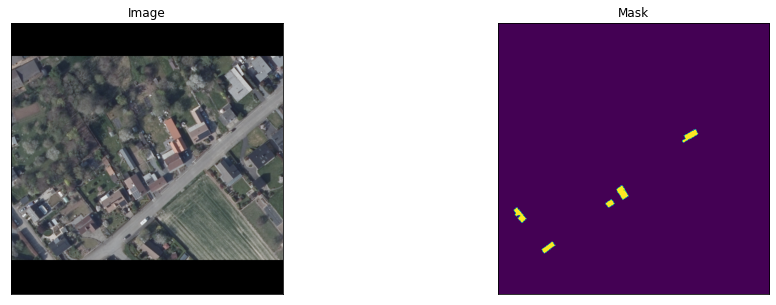

In [4]:
# Lets look at data we have
dataset = Dataset(x_train_dir, y_train_dir, classes=['solar panel'])

image, mask = dataset[5] # get some sample
visualize(
    image=image, 
    mask=mask.squeeze(),
)

# 4. Augmentations
As we have a small dataset, we want to increase the amount of data and prevent model overfitting. 
For this task, we will apply a large number of different augmentations :
* horizontal flip
* affine transforms
* perspective transforms
* brightness/contrast/colors manipulations
* image bluring and sharpening
* gaussian noise
* random crops

To do so, we will use the library called 'Albumentations'.

### 4.1. Visualization of augmented results

C:\Users\Admin\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1800: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(
C:\Users\Admin\anaconda3\lib\site-packages\albumentations\augmentations\transforms.py:1826: FutureWarning: This class has been deprecated. Please use RandomBrightnessContrast
  warnings.warn(


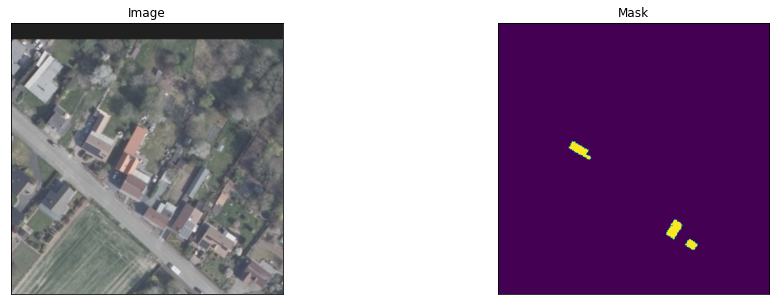

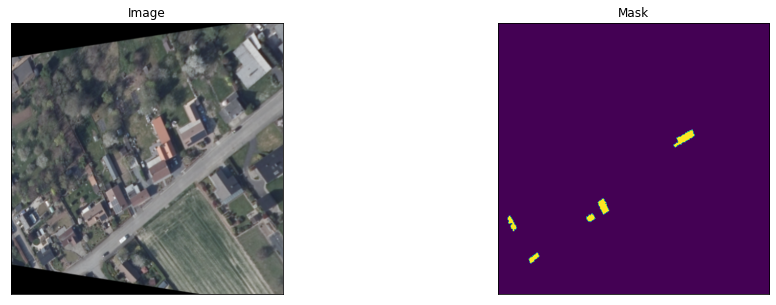

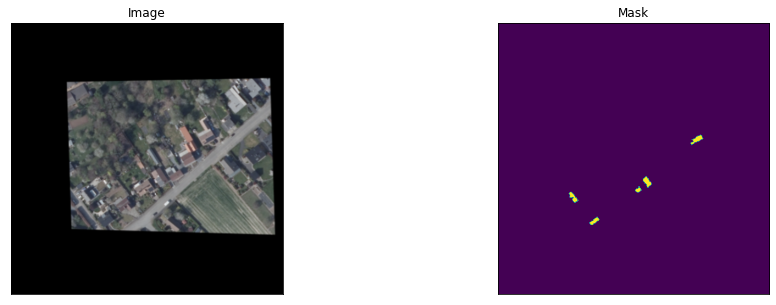

In [5]:
augmented_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    classes=['solar panel'],
)

# same image with different random transforms
for i in range(3):
    image, mask = augmented_dataset[5]
    visualize(image=image, mask=mask.squeeze(-1))

# 5. Setting up training environment

### 5.1. Global parameters

In [6]:
ENCODER = 'resnet101'
ENCODER_WEIGHTS = 'imagenet'
CLASSES = ['solar panel']
ACTIVATION = 'sigmoid' # could be None for logits or 'softmax2d' for multiclass segmentation
DEVICE = 'cuda'

preprocessing_fn = smp.encoders.get_preprocessing_fn(ENCODER, ENCODER_WEIGHTS)

### 5.2. Data preparation

In [7]:
train_dataset = Dataset(
    x_train_dir, 
    y_train_dir, 
    augmentation=get_training_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

valid_dataset = Dataset(
    x_valid_dir, 
    y_valid_dir, 
    augmentation=get_validation_augmentation(), 
    preprocessing=get_preprocessing(preprocessing_fn),
    classes=CLASSES,
)

train_loader = DataLoader(train_dataset, batch_size=3, shuffle=True, num_workers=0)
valid_loader = DataLoader(valid_dataset, batch_size=1, shuffle=False, num_workers=0)

### 5.3. Loss and metrics

In [8]:
# Loss
loss = smp.losses.SoftBCEWithLogitsLoss()
loss.__name__ = "SoftBCEWithLogitsLoss"

# Metrics
metrics = [
    smp.utils.metrics.IoU(threshold=0.5),
    smp.utils.metrics.Fscore(),
    smp.utils.metrics.Accuracy(),
    smp.utils.metrics.Recall(),
    smp.utils.metrics.Precision(),
]

# 6. Unet

### 6.1. Setting up model

In [9]:
# create segmentation model with pretrained encoder
model = smp.Unet(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# Optimization
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

### 6.2. Training

#### 6.4.1. Creating epoch runners

In [10]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

##### 6.4.2. Training the model for 100 epochs

In [11]:
# Train model for 100 epochs

max_score = 0
train_logs = []
valid_logs = []

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_unet.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train: 100%|█| 38/38 [00:43<00:00,  1.16s/it, SoftBCEWithLogitsLoss - 0.9114, iou_score - 0.009178, fscore - 0.01807, a
valid: 100%|█| 26/26 [00:03<00:00,  7.29it/s, SoftBCEWithLogitsLoss - 0.8929, iou_score - 0.01483, fscore - 0.02825, ac
Model saved!

Epoch: 1
train: 100%|█| 38/38 [00:33<00:00,  1.13it/s, SoftBCEWithLogitsLoss - 0.8344, iou_score - 0.01557, fscore - 0.02684, ac
valid: 100%|█| 26/26 [00:03<00:00,  7.68it/s, SoftBCEWithLogitsLoss - 0.8068, iou_score - 0.00599, fscore - 0.01094, ac

Epoch: 2
train: 100%|█| 38/38 [00:33<00:00,  1.13it/s, SoftBCEWithLogitsLoss - 0.802, iou_score - 0.03065, fscore - 0.05181, acc
valid: 100%|█| 26/26 [00:03<00:00,  7.77it/s, SoftBCEWithLogitsLoss - 0.7972, iou_score - 0.008489, fscore - 0.01422, a

Epoch: 3
train: 100%|█| 38/38 [00:34<00:00,  1.11it/s, SoftBCEWithLogitsLoss - 0.786, iou_score - 0.01065, fscore - 0.01865, acc
valid: 100%|█| 26/26 [00:03<00:00,  7.49it/s, SoftBCEWithLogitsLoss - 0.8307, iou_score - 0.002914, fscore 

In [12]:
#!jupyter nbconvert --to script Training.ipynb

In [13]:
with open("train_logs_unet.json", "w") as write_file:
    json.dump(train_logs, write_file)

In [14]:
with open("valid_logs_unet.json", "w") as write_file:
    json.dump(train_logs, write_file)

# 7. DeepLabV3

In [15]:
#gc.collect()

#torch.cuda.empty_cache()

### 7.1. Setting up model

In [16]:
# create segmentation model with pretrained encoder
model = smp.DeepLabV3(
    encoder_name=ENCODER, 
    encoder_weights=ENCODER_WEIGHTS, 
    classes=len(CLASSES), 
    activation=ACTIVATION,
)

# Optimization
optimizer = torch.optim.Adam([ 
    dict(params=model.parameters(), lr=0.0001),
])

### 7.2. Training

#### 7.2.1. Creating epoch runners

In [17]:
train_epoch = smp.utils.train.TrainEpoch(
    model, 
    loss=loss, 
    metrics=metrics, 
    optimizer=optimizer,
    device=DEVICE,
    verbose=True,
)

valid_epoch = smp.utils.train.ValidEpoch(
    model, 
    loss=loss, 
    metrics=metrics,
    device=DEVICE,
    verbose=True,
)

##### 7.2.2. Training the model for 100 epochs

In [18]:
# Train model for 100 epochs

max_score = 0
train_logs = []
valid_logs = []

for i in range(0, 100):
    
    print('\nEpoch: {}'.format(i))
    train_logs = train_epoch.run(train_loader)
    valid_logs = valid_epoch.run(valid_loader)
    
    # do something (save model, change lr, etc.)
    if max_score < valid_logs['iou_score']:
        max_score = valid_logs['iou_score']
        torch.save(model, './best_model_deeplab.pth')
        print('Model saved!')
        
    if i == 25:
        optimizer.param_groups[0]['lr'] = 1e-5
        print('Decrease decoder learning rate to 1e-5!')


Epoch: 0
train:   0%|                                                                                    | 0/38 [00:01<?, ?it/s]


RuntimeError: CUDA out of memory. Tried to allocate 86.00 MiB (GPU 0; 6.00 GiB total capacity; 4.12 GiB already allocated; 45.94 MiB free; 4.46 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF

In [ ]:
with open("train_logs_deeplab.json", "w") as write_file:
    json.dump(train_logs, write_file)

In [ ]:
with open("valid_logs_deeplab.json", "w") as write_file:
    json.dump(train_logs, write_file)

In [19]:
#!jupyter nbconvert --to script Training.ipynb

[NbConvertApp] Converting notebook Training.ipynb to script
[NbConvertApp] Writing 7105 bytes to Training.py
